In [ ]:
import pandas as pd
import numpy as np
import time
import requests
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report, accuracy_score

import nltk
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize

import yfinance as yf
import praw

from nltk.sentiment.vader import SentimentIntensityAnalyzer

nltk.download('stopwords')
nltk.download('punkt')
nltk.download('vader_lexicon')
nltk.download('punkt_tab')

%matplotlib inline

In [32]:
import praw

reddit = praw.Reddit(
    client_id="YOUR_CLIENT_ID_HERE",
    client_secret="YOUR_CLIENT_SECRET_HERE",
    user_agent="reddit_sentiment_bot_v1"
)

subreddits = ["wallstreetbets", "investing", "stocks"]

In [33]:
def fetch_pushshift_posts(subreddit, days_back=180, limit=500):
    """Use Pushshift.io API to get historical posts"""
    base_url = "https://api.pushshift.io/reddit/search/submission"
    
    end_time = int(time.time())
    start_time = end_time - (days_back * 24 * 60 * 60)
    
    params = {
        'subreddit': subreddit,
        'size': min(limit, 500),
        'after': start_time,
        'before': end_time,
        'sort_type': 'created_utc',
        'sort': 'desc'
    }
    
    try:
        response = requests.get(base_url, params=params, timeout=30)
        if response.status_code == 200:
            data = response.json()['data']
            posts = []
            for post in data:
                posts.append({
                    "subreddit": subreddit,
                    "title": post.get('title', ''),
                    "score": post.get('score', 0),
                    "num_comments": post.get('num_comments', 0),
                    "created_utc": pd.to_datetime(post.get('created_utc', 0), unit='s'),
                    "upvote_ratio": post.get('upvote_ratio', 0.5),
                    "source": "pushshift"
                })
            return posts
        else:
            print(f"Pushshift API error for r/{subreddit}: {response.status_code}")
            return []
    except Exception as e:
        print(f"Error with Pushshift for r/{subreddit}: {e}")
        return []

def comprehensive_data_collection():
    """Collect data from multiple sources and timeframes"""
    all_posts = []
    

    print("=== Collecting Recent High-Engagement Posts ===")
    for sub in subreddits:
        for time_filter in ['week', 'month']:
            try:
                subreddit = reddit.subreddit(sub)
                print(f"Fetching r/{sub} top posts from {time_filter}...")
                for post in subreddit.top(time_filter=time_filter, limit=300):
                    all_posts.append({
                        "subreddit": sub,
                        "title": post.title,
                        "score": post.score,
                        "num_comments": post.num_comments,
                        "created_utc": pd.to_datetime(post.created_utc, unit="s"),
                        "upvote_ratio": post.upvote_ratio,
                        "source": f"praw_{time_filter}"
                    })
            except Exception as e:
                print(f"Error with r/{sub} {time_filter}: {e}")
    

    print("\n=== Collecting Historical Data (Last 6 Months) ===")
    for sub in subreddits:
        print(f"Fetching historical posts from r/{sub}...")
        historical_posts = fetch_pushshift_posts(sub, days_back=180, limit=400)
        all_posts.extend(historical_posts)
        print(f"  Found {len(historical_posts)} historical posts")
        time.sleep(1.5)  # Rate limiting
    
 
    df = pd.DataFrame(all_posts)
    

    df = df.drop_duplicates(subset=['title', 'created_utc'])
    

    df = df.sort_values('created_utc', ascending=True).reset_index(drop=True)
    
    print(f"\n=== DATA COLLECTION COMPLETE ===")
    print(f"Total unique posts collected: {len(df)}")
    print(f"Date range: {df['created_utc'].min().strftime('%Y-%m-%d')} to {df['created_utc'].max().strftime('%Y-%m-%d')}")
    print(f"Sources: {df['source'].value_counts().to_dict()}")
    
    return df


df = comprehensive_data_collection()
df.head()

=== Collecting Recent High-Engagement Posts ===
Fetching r/wallstreetbets top posts from week...
Fetching r/wallstreetbets top posts from month...
Fetching r/investing top posts from week...
Fetching r/investing top posts from month...
Fetching r/stocks top posts from week...
Fetching r/stocks top posts from month...

=== Collecting Historical Data (Last 6 Months) ===
Fetching historical posts from r/wallstreetbets...
Pushshift API error for r/wallstreetbets: 403
  Found 0 historical posts
Fetching historical posts from r/investing...
Pushshift API error for r/investing: 403
  Found 0 historical posts
Fetching historical posts from r/stocks...
Pushshift API error for r/stocks: 403
  Found 0 historical posts

=== DATA COLLECTION COMPLETE ===
Total unique posts collected: 1126
Date range: 2025-09-23 to 2025-10-23
Sources: {'praw_week': 569, 'praw_month': 557}


,subreddit,title,score,num_comments,created_utc,upvote_ratio,source
0,wallstreetbets,Daddy Powell just kicked us in the balls “Stoc...,7392,695,2025-09-23 18:04:30,0.93,praw_month
1,wallstreetbets,10 Years ago my net worth was $0,1544,142,2025-09-23 18:29:55,0.97,praw_month
2,stocks,Fed Chief Powell says stock prices appear 'fai...,1105,169,2025-09-23 18:56:49,0.96,praw_month
3,investing,Powell Spoke Today – Here’s the Vibe Check,327,139,2025-09-23 19:07:16,0.87,praw_month
4,wallstreetbets,JPow with SPY,5417,169,2025-09-23 19:38:49,0.97,praw_month


In [34]:
stop_words = set(stopwords.words('english'))

def preprocess(text):
    tokens = word_tokenize(text.lower())
    tokens = [t for t in tokens if t.isalpha() and t not in stop_words]
    return " ".join(tokens)

df["cleaned_title"] = df["title"].apply(preprocess)
df['cleaned_title'].to_csv('reddit_posts.txt', index=False, header=False)
df.head()

,subreddit,title,score,num_comments,created_utc,upvote_ratio,source,cleaned_title
0,wallstreetbets,Daddy Powell just kicked us in the balls “Stoc...,7392,695,2025-09-23 18:04:30,0.93,praw_month,daddy powell kicked us balls stocks overvalued
1,wallstreetbets,10 Years ago my net worth was $0,1544,142,2025-09-23 18:29:55,0.97,praw_month,years ago net worth
2,stocks,Fed Chief Powell says stock prices appear 'fai...,1105,169,2025-09-23 18:56:49,0.96,praw_month,fed chief powell says stock prices appear high...
3,investing,Powell Spoke Today – Here’s the Vibe Check,327,139,2025-09-23 19:07:16,0.87,praw_month,powell spoke today vibe check
4,wallstreetbets,JPow with SPY,5417,169,2025-09-23 19:38:49,0.97,praw_month,jpow spy


In [35]:
from transformers import AutoTokenizer, AutoModelForSequenceClassification, pipeline

finbert_model = pipeline(
    "sentiment-analysis",
    model="ProsusAI/finbert",
    tokenizer="ProsusAI/finbert"
)

def finbert_sentiment(text):
    try:
        result = finbert_model(text[:512])[0]
        #positive=1.0, negative=-1.0, neutral=0.0
        if result['label'] == 'positive':
            return 1.0
        elif result['label'] == 'negative':
            return -1.0
        else:
            return 0.0
    except:
        return 0.0

print("Analyzing sentiment with FinBERT (this may take a few minutes)...")
df["sentiment"] = df["title"].apply(finbert_sentiment) 

Device set to use cpu


Analyzing sentiment with FinBERT (this may take a few minutes)...


In [36]:
df["date"] = df["created_utc"].dt.date

daily_sentiment = df.groupby("date")["sentiment"].mean().reset_index()
daily_sentiment.columns = ["date", "avg_sentiment"]

daily_sentiment.head()

print(daily_sentiment.head())

         date  avg_sentiment
0  2025-09-23       0.100000
1  2025-09-24       0.103448
2  2025-09-25       0.000000
3  2025-09-26       0.136364
4  2025-09-27       0.076923


In [ ]:
import yfinance as yf

start_date = daily_sentiment["date"].min()
end_date = daily_sentiment["date"].max()

ticker = "NVDA"
stock_data = yf.download(ticker, start=start_date, end=end_date, auto_adjust=False)

stock_data = stock_data.reset_index()

stock_data = stock_data[["Date", "Adj Close"]]
stock_data.columns = ["date", "adj_close"]

stock_data.head()

        date   adj_close  adj_close_pct_change  next_day_return  target
0 2025-09-23  178.429993                   NaN        -0.008182       0
1 2025-09-24  176.970001             -0.008182         0.004068       1
2 2025-09-25  177.690002              0.004068         0.002814       1
3 2025-09-26  178.190002              0.002814         0.020540       1
4 2025-09-29  181.850006              0.020540         0.026010       1


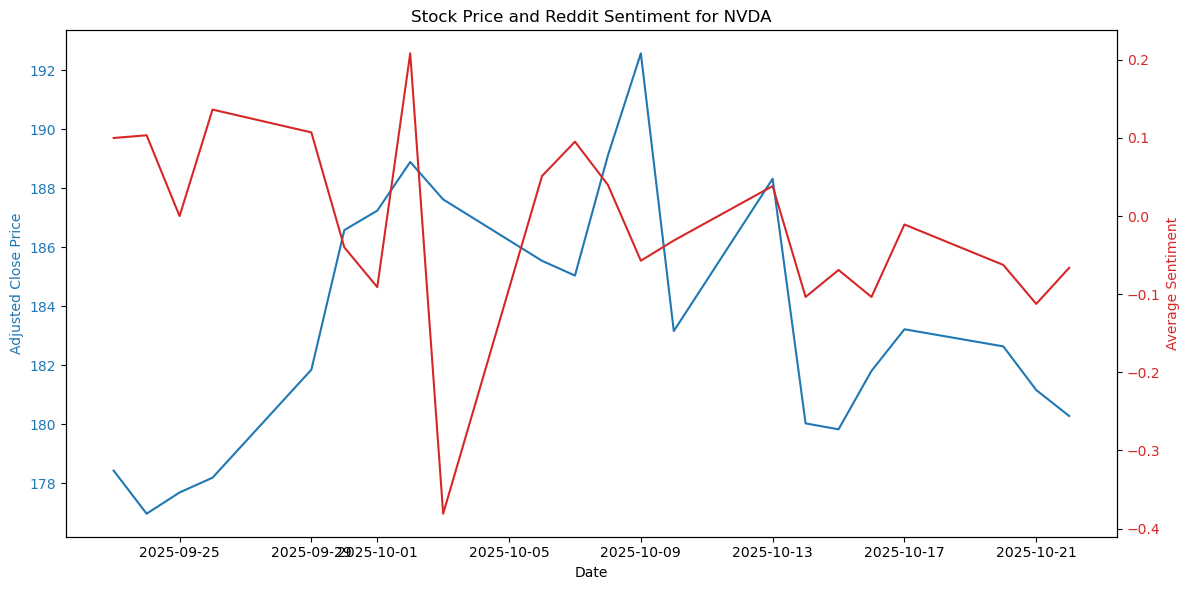

In [38]:
daily_sentiment['date'] = pd.to_datetime(daily_sentiment['date'])
stock_data['date'] = pd.to_datetime(stock_data['date'])

merged_df = pd.merge(daily_sentiment, stock_data, on="date", how="inner")

merged_df['adj_close_pct_change'] = merged_df['adj_close'].pct_change()
merged_df['next_day_return'] = merged_df['adj_close_pct_change'].shift(-1)
merged_df['target'] = (merged_df['next_day_return'] > 0).astype(int)
merged_df = merged_df.dropna(subset=['target'])

print(merged_df[['date', 'adj_close', 'adj_close_pct_change', 'next_day_return', 'target']].head())

import matplotlib.pyplot as plt

fig, ax1 = plt.subplots(figsize=(12,6))


ax1.set_xlabel('Date')
ax1.set_ylabel('Adjusted Close Price', color='tab:blue')
ax1.plot(merged_df['date'], merged_df['adj_close'], color='tab:blue', label='Adj Close Price')
ax1.tick_params(axis='y', labelcolor='tab:blue')


ax2 = ax1.twinx()
ax2.set_ylabel('Average Sentiment', color='tab:red')
ax2.plot(merged_df['date'], merged_df['avg_sentiment'], color='tab:red', label='Avg Sentiment')
ax2.tick_params(axis='y', labelcolor='tab:red')

plt.title(f'Stock Price and Reddit Sentiment for {ticker}')
fig.tight_layout()
plt.show()
